In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
import xgboost as xgb
# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 200)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

In [12]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
data = pd.concat([train, test], axis=0, ignore_index=True)
train.head()

,客户ID,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,...,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用,是否流失
0,0,7,0,-1,181,0,2,0,0,3,...,24,286,91,351,121,23,303,101,25,0
1,1,13,1,0,1399,0,3,0,0,0,...,44,447,190,483,199,40,488,202,44,1
2,2,14,1,0,927,0,2,4,0,6,...,48,183,79,271,95,71,209,77,54,0
3,3,1,0,0,232,0,3,-1,1,-1,...,42,303,166,473,226,72,446,219,65,1
4,4,0,-1,0,699,0,1,2,0,3,...,36,119,24,88,15,35,106,21,37,1


In [ ]:
# 一次性画所有特征分布
fig = plt.figure(figsize=(18,120)) 
for i,col in enumerate(train.columns[1:69]):
    # 遍历子图
    ax = fig.add_subplot(17, 5, i+1)
    sns.boxplot(x='是否流失', y=col, hue='是否流失', data=train, ax=ax)
    # 子图的标题
    # ax.set_title(lst[i])
    # 设置子图之间的横纵边距
    plt.subplots_adjust(wspace=0.5,hspace=0.3)

## 特征选择

### 1、移除低方差特征

删除了所有方差不满足某些阈值的特征。默认情况下，它删除所有零方差特征，即在所有样本中具有相同值的特征。(没什么区分性，直接剔除即可)

In [4]:
from sklearn.feature_selection import VarianceThreshold

In [31]:
X = train.drop(['客户ID','是否流失'], axis=1)
sel = VarianceThreshold(threshold=0.1)  # 删除低方差特征
X_trans = sel.fit_transform(X)

In [32]:
print(X.shape,X_trans.shape )
X.columns[np.where(sel.get_support(indices=False) == False)] # 返回剔除特征对应的索引\特征

(150000, 67) (150000, 65)


Index(['是否翻新机', '账户消费限额'], dtype='object')

In [30]:
train.groupby(['账户消费限额','是否流失'])['是否流失'].count()

账户消费限额  是否流失
0       0       66886
        1       69807
1       0        8072
        1        5235
Name: 是否流失, dtype: int64

计算相关性

In [24]:
# 计算特征相关性系数
def correlation(data,thred):
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if abs(corr_mat.iloc[i, j]) > thred:
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

all_cols = [c for c in data.columns if c not in ['是否流失','客户ID']]
corr_features = correlation(data[all_cols],0.8)
corr_features

{'一分钟内的平均呼入电话数',
 '使用客户服务电话的平均分钟数',
 '使用高峰语音通话的平均不完整分钟数',
 '完成数据调用的平均数',
 '客户整个生命周期内的平均每月通话次数',
 '客户生命周期内的平均每月使用分钟数',
 '客户生命周期内的总使用分钟数',
 '客户生命周期内的总费用',
 '尝试拨打的平均语音呼叫次数',
 '已完成语音通话的平均使用分钟数',
 '平均呼入和呼出高峰语音呼叫数',
 '平均完成的语音呼叫数',
 '平均尝试调用次数',
 '平均峰值数据调用次数',
 '平均已完成呼叫数',
 '平均掉线或占线呼叫数',
 '平均语音费用',
 '平均超额费用',
 '平均非高峰语音呼叫数',
 '计费调整后的呼叫总数',
 '计费调整后的总分钟数',
 '计费调整后的总费用',
 '过去三个月的平均月费用',
 '过去三个月的平均每月使用分钟数',
 '过去三个月的平均每月通话次数',
 '过去六个月的平均月费用',
 '过去六个月的平均每月使用分钟数',
 '过去六个月的平均每月通话次数',
 '非高峰数据呼叫的平均数量'}

### 2、单变量特征选择

In [39]:
from sklearn.feature_selection import SelectKBest # 移除那些除了评分最高的 K 个特征之外的所有特征
from sklearn.feature_selection import chi2 

# 对于分类，用卡方检验，特征的值必须非负
# 卡方检验可测量随机变量之间的相关性，因此使用此功能可以“淘汰”最有可能与类别无关的特征
X_non_negative = X.applymap(lambda x: max(x, 0))
sel = SelectKBest(chi2, k=12)
sel.fit_transform(X_non_negative, train['是否流失'])

array([[ 181,  325,  316, ...,  855,  351,  303],
       [1399,   90,  511, ..., 1936,  483,  488],
       [ 927,  285,  273, ..., 1963,  271,  209],
       ...,
       [1300,  467,  569, ..., 8513,  544,  531],
       [1399,   31,  377, ..., 3495,  233,  432],
       [1049,  386,  133, ...,  947,  147,  167]], dtype=int64)

In [40]:
# 剔除的特征
X.columns[np.where(sel.get_support(indices=False) == False)]

Index(['地理区域', '是否双频', '是否翻新机', '手机网络功能', '婚姻状况', '家庭成人人数', '信息库匹配', '预计收入',
       '信用卡指示器', '在职总月数', '家庭中唯一订阅者的数量', '家庭活跃用户数', '新手机用户', '信用等级代码', '平均月费用',
       '平均超额使用分钟数', '平均超额费用', '平均语音费用', '数据超载的平均费用', '平均漫游呼叫数',
       '当月使用分钟数与前三个月平均值的百分比变化', '当月费用与前三个月平均值的百分比变化', '平均掉线语音呼叫数', '平均丢弃数据呼叫数',
       '平均占线语音呼叫数', '平均占线数据调用次数', '平均未接语音呼叫数', '未应答数据呼叫的平均次数', '尝试拨打的平均语音呼叫次数',
       '尝试数据调用的平均数', '平均接听语音电话数', '平均完成的语音呼叫数', '完成数据调用的平均数', '平均客户服务电话次数',
       '使用客户服务电话的平均分钟数', '一分钟内的平均呼入电话数', '平均三通电话数', '平均呼入和呼出高峰语音呼叫数',
       '平均峰值数据调用次数', '平均非高峰语音呼叫数', '非高峰数据呼叫的平均数量', '平均掉线或占线呼叫数', '平均已完成呼叫数',
       '平均呼叫转移呼叫数', '平均呼叫等待呼叫数', '账户消费限额', '客户生命周期内的总费用', '计费调整后的总费用',
       '客户生命周期内平均月费用', '客户生命周期内的平均每月使用分钟数', '客户整个生命周期内的平均每月通话次数',
       '过去三个月的平均每月通话次数', '过去三个月的平均月费用', '过去六个月的平均每月通话次数', '过去六个月的平均月费用'],
      dtype='object')

### 3、递归特征消除

给定一个外部的估计器，可以对特征赋予一定的权重（比如，线性模型的相关系数），递归特征消除(RFE)通过考虑越来越小的特征集来递归的选择特征。

1. 首先，估计器在初始的特征集合上训练并且通过 coef_属性或者feature_importances_获取每一个特征的重要性。 
2. 然后，从当前的特征集合中移除最不重要的特征。
3. 在特征集合上不断的重复递归这个步骤，直到最终达到所需要的特征数量为止。

使用**交叉验证自动调整所选择的特征数**（特征较多就比较耗时）

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV

X = train.drop(['客户ID','是否流失'], axis=1)
y = train['是否流失']

# Create the RFE object and compute a cross-validated score.
rf = RandomForestClassifier(max_depth=6,random_state=0)

# classifications
rfecv = RFECV(estimator=rf, step=1, cv=KFold(2),
              scoring='roc_auc')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### 4、基于SelectFromModel的特征选择

SelectFromModel是一个元转换器(meta-transformer)，它可以与任何具有 coef_属性或feature_importances_属性的估值器一起使用。

如果相应的coef_或 feature_importances_低于所提供的阈值参数，则这些特征被视为不重要并被删除。

除了指定在数值上的阈值外，还可以通过给定字符串参数来使用内置的启发式方法找到一个合适的阈值。可用的启发式方法是“mean”, “median” 和浮点倍数，如 “0.1*mean”。结合阈值标准，可以使用max_features参数来设置要选择的特征数量的限制。

In [ ]:
from sklearn.linear_model import LassoCV,LinearSVC

clf = LinearSVC(random_state=0, max_iter=100,penalty="l1")
clf.fit(X, y)
importances = np.abs(clf.coef_)
print(importances)

In [ ]:
# SelectFromModel()允许设置阈值
# 只有coef_高于阈值的特征才能保持不变。
# 计算的第10个最高coef_.
idx_third = importance.argsort()[-10]
threshold = importance[idx_third] + 0.01


idx_features = (-importance).argsort()[:9]
name_features = np.array(feature_names)[idx_features]
print(f'Selected features: {name_features}')

In [ ]:
sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

### 基于树的特征选择

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [7]:
X = train.drop(['客户ID','是否流失'], axis=1)
y = train['是否流失']

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape 

(150000, 44)

In [8]:
# 剔除的特征
X.columns[np.where(model.get_support(indices=False) == False)]

Index(['是否双频', '是否翻新机', '手机网络功能', '信息库匹配', '信用卡指示器', '家庭中唯一订阅者的数量', '家庭活跃用户数',
       '新手机用户', '数据超载的平均费用', '平均漫游呼叫数', '平均丢弃数据呼叫数', '平均占线数据调用次数',
       '未应答数据呼叫的平均次数', '尝试数据调用的平均数', '完成数据调用的平均数', '平均客户服务电话次数',
       '使用客户服务电话的平均分钟数', '平均三通电话数', '平均峰值数据调用次数', '非高峰数据呼叫的平均数量', '平均呼叫转移呼叫数',
       '平均呼叫等待呼叫数', '账户消费限额'],
      dtype='object')

## 5、特征的置换重要性——permutation_importance

首先，在X定义的（可能不同的）数据集上评估通过评分定义的基线度量。

接着，对验证集中的特征列进行置换，并再次评估度量。 

**排列重要性定义为基线度量和来自排列特征列的度量之间的差异**

当单个特征的值被随机打散后，模型评分下降的程度。**模型评分下降的程度，就是模型依赖于该特征的程度**。**对非线性表格数据比较有效。**

In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

train, test, y_train, y_test = train_test_split(X,y,random_state=2022,test_size=0.25)

def model(train,y_train,test,y_test):
    lgb_model = LGBMClassifier(num_leaves=100,
                           max_depth=10,
                           boosting_type='gbdt',
                           learning_rate=0.1,
                           n_estimators=100,
                           objective='binary',
                           subsample=0.8, 
                           colsample_bytree=1, 
                           reg_alpha=0.1,
                           reg_lambda=0.1,
                           metrics='auc',
                           random_state=2022
                           )

    lgb_model.fit(train,
                y_train,
                eval_set=[(test,y_test)],
                eval_metric='auc',
                verbose=-1
                )

    y_pre = lgb_model.predict(test)
    return (accuracy_score(y_test,y_pre))

# 初始的模型评分
score = model(train,y_train,test,y_test)

In [10]:
# 列随机打散
def shuffle_col(df):
    df = df.sample(frac=1.0,axis=0,random_state=2022)
    df = df.reset_index(drop=True)
    return df

columns = train.columns

score_down=[]
for col in columns:
    train[[col]] = shuffle_col(train[[col]])
    new_score = model(train,y_train,test,y_test)
    col_score_down = score - new_score
    score_down.append(col_score_down)

fea_importance = pd.DataFrame({'col':columns,'score_down':score_down})
fea_importance.sort_values(by=['score_down'],ascending=False).reset_index(drop=True)

,col,score_down
0,过去六个月的平均月费用,0.160773
1,过去六个月的平均每月通话次数,0.155227
2,过去六个月的平均每月使用分钟数,0.146773
3,过去三个月的平均月费用,0.142613
4,过去三个月的平均每月通话次数,0.134533
5,过去三个月的平均每月使用分钟数,0.126453
6,客户整个生命周期内的平均每月通话次数,0.124560
7,客户生命周期内的平均每月使用分钟数,0.113387
8,客户生命周期内平均月费用,0.109813
9,计费调整后的呼叫总数,0.107360


## 6、null_importance 

有些假设检验的意思，实际lable拟合的特征重要性与随机shuffle label建模得到的特征重要性的差距是否足够显著，按照设计并计算得到的Score进行批量的特征筛选，并计算线下验证分数，选用线下分数最好的一些特征作为最终的特征。

Null Importance算法的实现步骤为：

1. 在原始数据集上运行模型并且记录每个特征重要性。以此作为基准；
2. 构建Null importances分布：对我们的标签进行随机Shuffle，并且计算shuffle之后的特征的重要性；
3. 对2进行多循环操作，得到多个不同shuffle之后的特征重要性；
4. 设计score函数，得到未shuffle的特征重要性与shuffle之后特征重要性的偏离度，并以此设计特征筛选策略；
5. 计算不同筛选情况下的模型的分数，并进行记录；
6. 将分数最好的几个分数对应的特征进行返回。

In [13]:
def get_feature_importances(data,label,shuffle,seed=None):
    # 非id、label的特征
    train_features = [f for f in data.columns if f not in [label,'客户ID']]
    y = data[label].copy()

    if shuffle:
        # label随机打散
        y = data[label].copy().sample(frac=1.0)

    # 模型训练
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'verbose':-1,
        'n_jobs': 4
    }

    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # 特征重要性
    imp_df = pd.DataFrame()
    imp_df['feature'] = list(train_features)
    imp_df['importance_gain'] = clf.feature_importance(importance_type='gain')
    imp_df['importance_split'] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y,clf.predict(data[train_features]))

    return imp_df


# 获取原始数据的特征重要性
actual_imp_df =  get_feature_importances(data=train,label='是否流失',shuffle=False,seed=2022)

In [14]:
# target shuffle 特征重要性

null_imp_df = pd.DataFrame()
nb_runs = 30
import time
start = time.time()
dsp = ''

for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, label='是否流失',shuffle=True)
    imp_df['run'] = i + 1 
    # 每一轮shuffle的结果追加
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   30 of   30 (Spent   1.5 min)

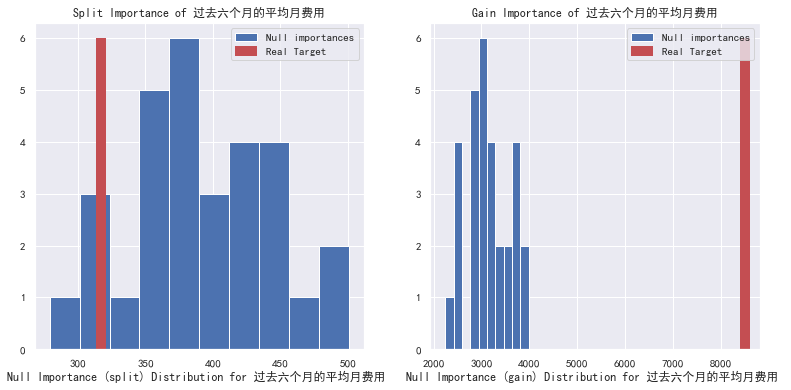

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())


# 【过去六个月的平均月费用】的特征重要性shuffle前后都很大，并且在一个数据级，所以为保留特征
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='过去六个月的平均月费用')

In [17]:
# Score计算方式1：以未进行特征shuffle的特征重要性除以shuffle之后的0.75分位数(进行了多轮shuffle，取特征重要性的0.75分位数)作为score

feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    
    feature_scores.append((_f, split_score, gain_score))


scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

# 过滤掉负值特征。特征shuffle之后，重要性还能变大，太扯淡了，直接丢了 
null_imp_features = scores_df[scores_df['gain_score'] <0]['feature'].values.tolist()
null_imp_features

['地理区域',
 '新手机用户',
 '数据超载的平均费用',
 '平均漫游呼叫数',
 '平均丢弃数据呼叫数',
 '平均占线语音呼叫数',
 '平均占线数据调用次数',
 '平均未接语音呼叫数',
 '未应答数据呼叫的平均次数',
 '尝试数据调用的平均数',
 '完成数据调用的平均数',
 '一分钟内的平均呼入电话数',
 '平均三通电话数',
 '平均峰值数据调用次数',
 '非高峰数据呼叫的平均数量',
 '平均呼叫转移呼叫数']

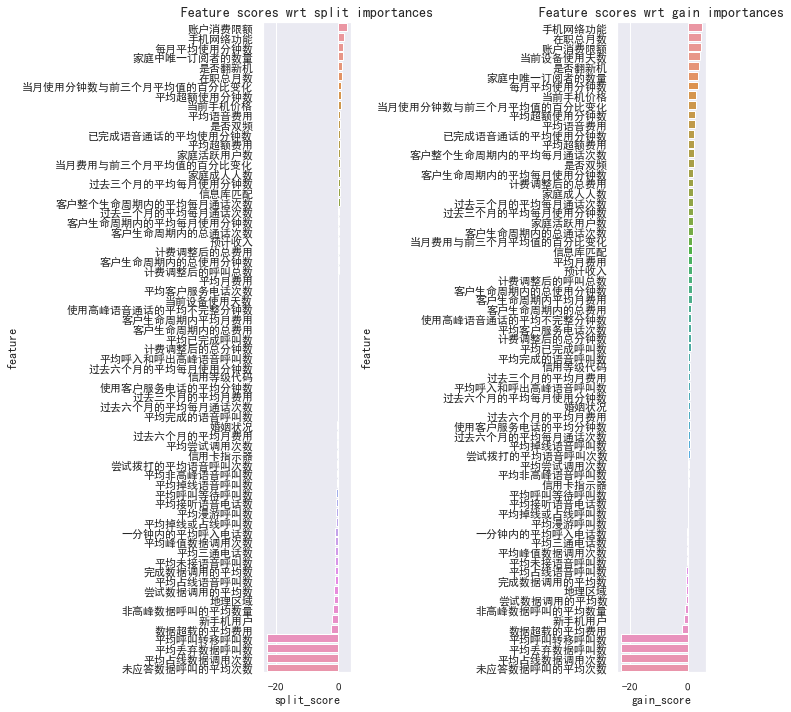

In [18]:
# 这里比较的是偏离度，偏离度越小（正数），特征重要性说服力越强
# 越接近0，说明该特征越重要。

plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [23]:
# score计算方式2：shuffle target之后特征重要性低于实际target对应特征的重要性0.25分位数的次数百分比
# 这里就是score越大越好。

correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

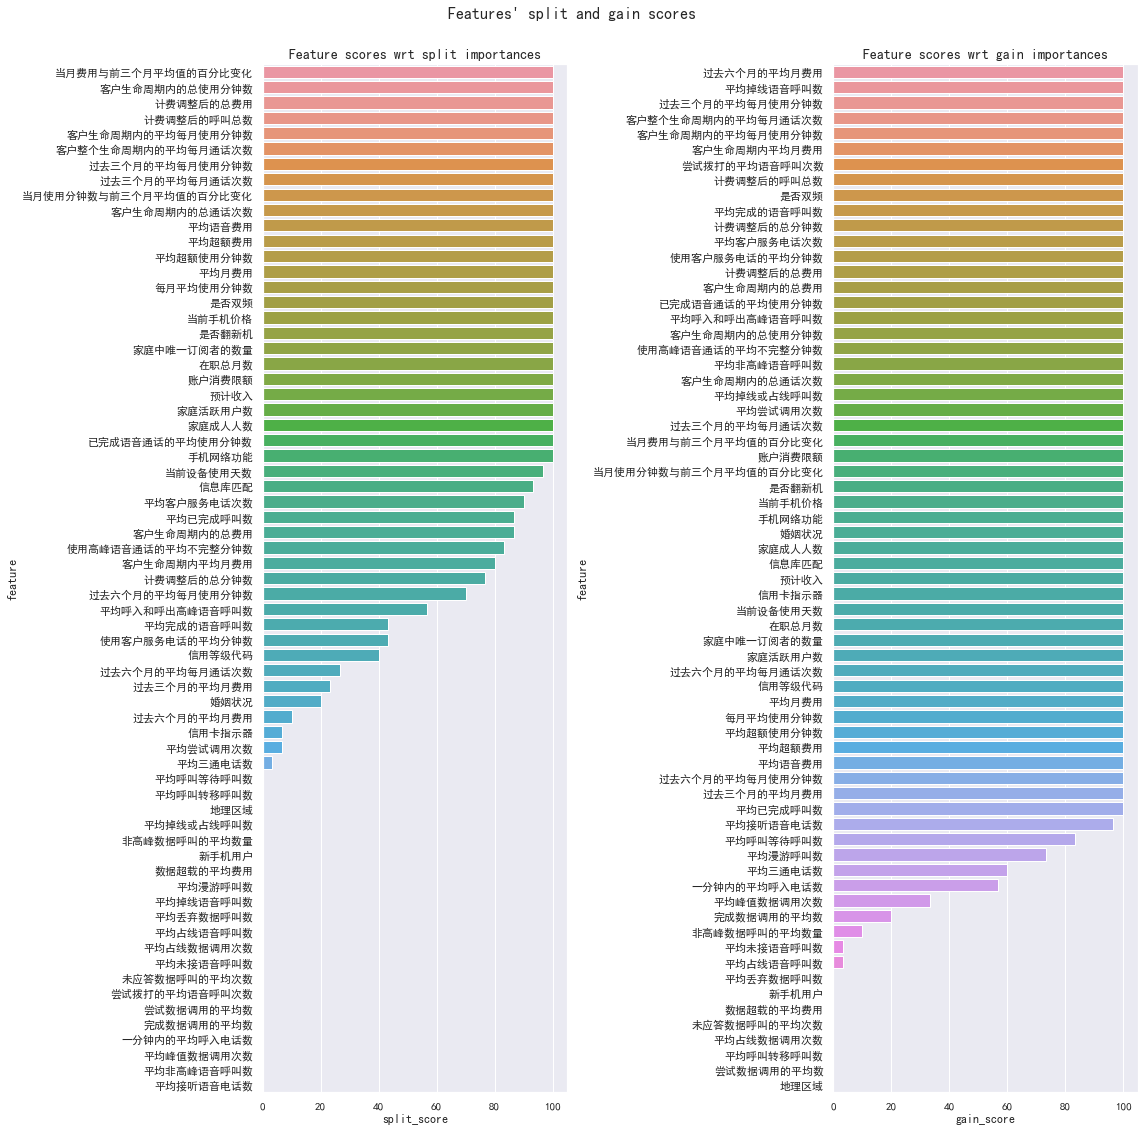

In [20]:
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)